In [1]:
from sklearn.metrics import mean_absolute_error as MSE
from cmcrameri import cm
from tqdm import tqdm
from common import *
from models import *

2021-12-15 22:21:14.046173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 22:21:14.046315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Reading in the data

In [2]:
df = pd.read_csv("../data/input_data/MAIN_DATASET.csv")

price = df['NO2_price'].values.reshape(-1,1)

price_days = seperate_column_to_days(price)

In [3]:
lookbehind = 7
input_width = lookbehind*24
horizon = 24
no_hours = input_width + horizon
hour_in_days = int(no_hours / 24)

price_dataset = []
for i in range(len(price_days) - hour_in_days+1):
    price_dataset.append(np.concatenate((price_days[i:i+hour_in_days])))

price_dataset = np.array(price_dataset)

scaler = MinMaxScaler()
price_dataset = scaler.fit_transform(price_dataset[:,:,0])
price_dataset = price_dataset[..., np.newaxis].astype(np.float32)

dataset = price_dataset
n,m,k = dataset.shape
print(n,m,k)

2145 192 1


In [4]:
train = int(0.7*n)
valid = int(0.9*n)
X_train = dataset[:train, :input_width]
X_valid = dataset[train:valid, :input_width]
X_test = dataset[valid:, :input_width]

Y = np.empty((n, input_width, horizon))
for step_ahead in range(1, horizon + 1):
    Y[:,:, step_ahead - 1] = dataset[:,step_ahead:step_ahead + input_width, 0]

Y_train = Y[:train]
Y_valid = Y[train:valid]
Y_test = Y[valid:]

The idea behind this grid search is to first study which cells performs the best for our current dataset, with a univariate model

# Common parameters for Grid Search

In [5]:
epochs = 10
no_neurons = np.array([16,32,64,128])
mse_list_small = np.zeros((3, len(no_neurons)))
best_mse_small = np.inf*np.ones(3)

In [6]:
for n, neurons in enumerate(no_neurons):
    print(f"Iteration {n}")
    rnn = keras.models.Sequential([
        keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    lstm = keras.models.Sequential([
        keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    gru = keras.models.Sequential([
        keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, 1]),
        keras.layers.Dense(horizon)
    ])

    rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
    gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

    rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
    gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

    Y_pred_rnn = rnn.predict(X_test)
    Y_pred_lstm = lstm.predict(X_test)
    Y_pred_gru = gru.predict(X_test)

    mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
    mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
    mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

    if mse_rnn < best_mse_small[0]:
        print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons} neurons")
        best_mse_small[0] = mse_rnn
        fname = f"../data/models/small_rnn.pkl"
        save_model(rnn, fname)

    if mse_lstm < best_mse_small[1]:
        print(f"Found new best LSTM mse {mse_lstm} with {neurons} neurons")
        best_mse_small[1] = mse_lstm
        fname = f"../data/models/small_lstm.pkl"
        save_model(lstm, fname)

    if mse_gru < best_mse_small[2]:
        print(f"Found new best GRU mse {mse_gru} with {neurons} neurons")
        best_mse_small[2] = mse_gru
        fname = f"../data/models/small_gru.pkl"
        save_model(gru, fname)

    mse_list_small[0,n] = mse_rnn
    mse_list_small[1,n] = mse_lstm
    mse_list_small[2,n] = mse_gru



Iteration 0


2021-12-15 22:21:16.132157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-12-15 22:21:16.132282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-15 22:21:16.132337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-15 22:21:16.132386: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-15 22:21:16.132434: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

Found new best SimpleRNN mse 0.16083823568663833 with 16 neurons


2021-12-15 22:22:21.968044: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://84f490ab-7626-495d-a652-8fd49bedfb75/assets
Found new best LSTM mse 0.11577260225617499 with 16 neurons


INFO:tensorflow:Assets written to: ram://cfa2075b-0724-4135-89b8-df5a61fdddac/assets


INFO:tensorflow:Assets written to: ram://cfa2075b-0724-4135-89b8-df5a61fdddac/assets


Found new best GRU mse 0.11849736350851703 with 16 neurons


INFO:tensorflow:Assets written to: ram://85c7f180-1beb-47da-a58f-fcdfa4fee5e8/assets


INFO:tensorflow:Assets written to: ram://85c7f180-1beb-47da-a58f-fcdfa4fee5e8/assets


Iteration 1
Found new best SimpleRNN mse 0.12801645769033443 with 32 neurons
INFO:tensorflow:Assets written to: ram://4a2047ce-5c4b-4727-b4ed-d257723881a8/assets


INFO:tensorflow:Assets written to: ram://4a2047ce-5c4b-4727-b4ed-d257723881a8/assets


Found new best LSTM mse 0.0992367416743678 with 32 neurons


INFO:tensorflow:Assets written to: ram://7cc091be-39fa-4a4f-9c8a-da3e7853cbf3/assets


INFO:tensorflow:Assets written to: ram://7cc091be-39fa-4a4f-9c8a-da3e7853cbf3/assets


Found new best GRU mse 0.10463614409973232 with 32 neurons


INFO:tensorflow:Assets written to: ram://ca408a4b-d13e-40a8-a8a2-043352f94a45/assets


INFO:tensorflow:Assets written to: ram://ca408a4b-d13e-40a8-a8a2-043352f94a45/assets


Iteration 2
Found new best SimpleRNN mse 0.10132479044785342 with 64 neurons
INFO:tensorflow:Assets written to: ram://13757f69-a655-4ec3-9d76-b1c82755f1ac/assets


INFO:tensorflow:Assets written to: ram://13757f69-a655-4ec3-9d76-b1c82755f1ac/assets


Found new best LSTM mse 0.09766448025594972 with 64 neurons


INFO:tensorflow:Assets written to: ram://de4eafd9-3047-414d-af53-f018a57705de/assets


INFO:tensorflow:Assets written to: ram://de4eafd9-3047-414d-af53-f018a57705de/assets


Found new best GRU mse 0.09227069816649257 with 64 neurons


INFO:tensorflow:Assets written to: ram://97a09e23-dce1-4c9a-8dfd-388ab3d56197/assets


INFO:tensorflow:Assets written to: ram://97a09e23-dce1-4c9a-8dfd-388ab3d56197/assets


Iteration 3
Found new best SimpleRNN mse 0.0742748405126275 with 128 neurons
INFO:tensorflow:Assets written to: ram://290079f1-7fc7-462c-98f8-6bacc2f04821/assets


INFO:tensorflow:Assets written to: ram://290079f1-7fc7-462c-98f8-6bacc2f04821/assets


Found new best LSTM mse 0.08990080165593438 with 128 neurons


INFO:tensorflow:Assets written to: ram://30881d53-aa1b-4951-b7c9-98bc8264a130/assets


INFO:tensorflow:Assets written to: ram://30881d53-aa1b-4951-b7c9-98bc8264a130/assets


Found new best GRU mse 0.08318204558389167 with 128 neurons


INFO:tensorflow:Assets written to: ram://cc54cc92-d866-4d67-8ad7-3bdab9084fba/assets


INFO:tensorflow:Assets written to: ram://cc54cc92-d866-4d67-8ad7-3bdab9084fba/assets


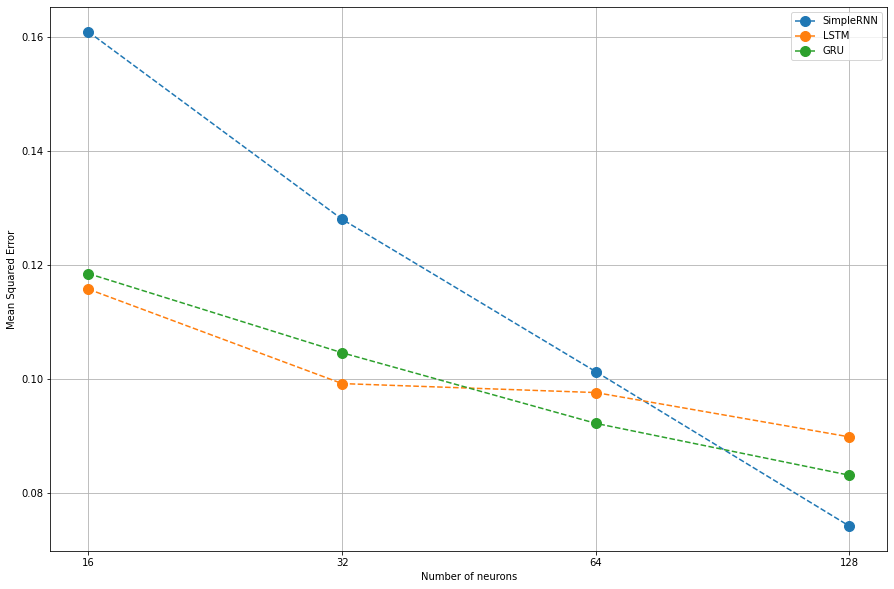

In [7]:
plt.figure(figsize=(15,10))
plt.plot(mse_list_small[0], '.--', markersize=20, label="SimpleRNN")
plt.plot(mse_list_small[1], '.--', markersize=20, label="LSTM")
plt.plot(mse_list_small[2], '.--', markersize=20, label="GRU")
plt.xticks(ticks = np.arange(4), labels=no_neurons)
plt.xlabel(f"Number of neurons")
plt.ylabel(f"Mean Squared Error")
plt.grid()
plt.legend()
#plt.savefig(f"../figures/small_architecture_grid_search.pdf")

# Perform the same gridsearch, but for large architecture

In [8]:
no_neurons = np.array([16,32,64,128])
mse_list = np.zeros((3, len(no_neurons), len(no_neurons)))
best_mse = np.inf*np.ones(3)

In [9]:
for n, neurons_first in enumerate(no_neurons):
    for m, neurons_second in enumerate(no_neurons):
        print(f"Iteration {n}{m}")
        rnn = keras.models.Sequential([
            keras.layers.SimpleRNN(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.SimpleRNN(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        lstm = keras.models.Sequential([
            keras.layers.LSTM(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.LSTM(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        gru = keras.models.Sequential([
            keras.layers.GRU(neurons_first, return_sequences=True, input_shape=[None, 1]),
            keras.layers.GRU(neurons_second, return_sequences=True),
            keras.layers.Dense(horizon)
        ])

        rnn.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        lstm.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
        gru.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])

        rnn.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        lstm.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)
        gru.fit(X_train, Y_train, epochs=epochs, validation_data=(X_valid, Y_valid), verbose=False)

        Y_pred_rnn = rnn.predict(X_test)
        Y_pred_lstm = lstm.predict(X_test)
        Y_pred_gru = gru.predict(X_test)

        mse_rnn = MSE(Y_test[:,-1], Y_pred_rnn[:,-1])
        mse_lstm = MSE(Y_test[:,-1], Y_pred_lstm[:,-1])
        mse_gru = MSE(Y_test[:,-1], Y_pred_gru[:,-1])

        if mse_rnn < best_mse[0]:
            print(f"Found new best SimpleRNN mse {mse_rnn} with {neurons_first} and {neurons_second} neurons")
            best_mse[0] = mse_rnn
            fname = f"../data/models/large_rnn.pkl"
            save_model(rnn, fname)

        if mse_lstm < best_mse[1]:
            print(f"Found new best LSTM mse {mse_lstm} with {neurons_first} and {neurons_second} neurons")
            best_mse[1] = mse_lstm
            fname = f"../data/models/large_lstm.pkl"
            save_model(lstm, fname)

        if mse_gru < best_mse[2]:
            print(f"Found new best GRU mse {mse_gru} with {neurons_first} and {neurons_second} neurons")
            best_mse[2] = mse_gru
            fname = f"../data/models/large_gru.pkl"
            save_model(gru, fname)

        mse_list[0,n,m] = mse_rnn
        mse_list[1,n,m] = mse_lstm
        mse_list[2,n,m] = mse_gru

Iteration 00


KeyboardInterrupt: 

In [ ]:
print(mse_list)
print(best_mse)

From these results, the best models are
* SimpleRNN 128 and 128 neurons @ 0.06939392 MSE
* LSTM 32 and 128 neurons @ 0.08641151
* GRU 32 and 128 neurons @ 0.08066217